In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import pickle

from lightgbm import LGBMRegressor
from sklearn.externals import joblib

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
root_folder = "./data"
train_file = path.join(root_folder,"train_features.pkl")

In [3]:
melted = pd.read_pickle(train_file)
melted.head()

,name,lang,access,agent,median,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff
126253,4052.0,5.0,0.0,1.0,9.0,2015-07-02,6.0,3,7,183,3,27,4.0,0.0
126737,14413.0,5.0,0.0,1.0,14275.0,2015-07-02,1121.0,3,7,183,3,27,19.0,-1311.0
126752,20018.0,5.0,0.0,1.0,498.0,2015-07-02,385.0,3,7,183,3,27,451.0,250.0
126754,20021.0,5.0,0.0,1.0,38.0,2015-07-02,71.0,3,7,183,3,27,80.0,37.0
126755,20024.0,5.0,0.0,1.0,50.0,2015-07-02,55.0,3,7,183,3,27,38.0,23.0


In [4]:
current_date = '2017-07-03'
train = melted[melted['date'] < current_date]
test = melted[melted['date'] >= current_date]
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84126586 entries, 126253 to 84356571
Data columns (total 14 columns):
name            float64
lang            float64
access          float64
agent           float64
median          float64
date            datetime64[ns]
hits            float64
day_of_week     int64
month           int64
day_of_year     int64
quarter         int64
week_of_year    int64
last_hits       float64
last_diff       float64
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 9.4 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8055880 entries, 84356572 to 92412451
Data columns (total 14 columns):
name            float64
lang            float64
access          float64
agent           float64
median          float64
date            datetime64[ns]
hits            float64
day_of_week     int64
month           int64
day_of_year     int64
quarter         int64
week_of_year    int64
last_hits       float64
last_diff       float64
dtypes: datetime64[ns](1

In [5]:
train.head()

,name,lang,access,agent,median,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff
126253,4052.0,5.0,0.0,1.0,9.0,2015-07-02,6.0,3,7,183,3,27,4.0,0.0
126737,14413.0,5.0,0.0,1.0,14275.0,2015-07-02,1121.0,3,7,183,3,27,19.0,-1311.0
126752,20018.0,5.0,0.0,1.0,498.0,2015-07-02,385.0,3,7,183,3,27,451.0,250.0
126754,20021.0,5.0,0.0,1.0,38.0,2015-07-02,71.0,3,7,183,3,27,80.0,37.0
126755,20024.0,5.0,0.0,1.0,50.0,2015-07-02,55.0,3,7,183,3,27,38.0,23.0


In [6]:
test.head()

,name,lang,access,agent,median,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff
84356572,588.0,7.0,0.0,1.0,18.0,2017-07-03,26.0,0,7,184,3,27,24.0,1.0
84356573,589.0,7.0,0.0,1.0,19.0,2017-07-03,16.0,0,7,184,3,27,26.0,11.0
84356574,643.0,7.0,0.0,1.0,3.0,2017-07-03,7.0,0,7,184,3,27,1.0,0.0
84356575,683.0,7.0,0.0,1.0,14.0,2017-07-03,16.0,0,7,184,3,27,19.0,12.0
84356576,699.0,7.0,0.0,1.0,15.0,2017-07-03,29.0,0,7,184,3,27,10.0,0.0


In [7]:
%%time
mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01,categorical_feature=[0,1,2,3])
mdl.fit(train.drop(columns=['hits','date']),np.log1p(train['hits']))

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


CPU times: user 5h 45min 56s, sys: 46 s, total: 5h 46min 42s
Wall time: 29min 36s


In [8]:
p = mdl.predict(test.drop(columns=['hits','date']))

In [9]:
p = np.expm1(p)
p = np.maximum(p,0)

In [10]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [13]:
print("RMSLE Error %.5f" % (rmsle(test['hits'],p)))

Error 0.40738


In [22]:
print("Mean absolute error %.5f" % mean_absolute_error(test['hits'],p))

Mean absolute error 434.90667


In [23]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [24]:
print("SMAPE %.5f" % smape(test['hits'],p))

SMAPE 27.07146


In [15]:
test['prediction'] = np.round(p)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
page = test[test['name'] == 33809.0][test['lang'] == 4.0][test['access'] == 0.0][test['agent'] == 0.0]
page

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,name,lang,access,agent,median,date,hits,day_of_week,month,day_of_year,quarter,week_of_year,last_hits,last_diff,prediction
84450395,33809.0,4.0,0.0,0.0,769.0,2017-07-03,574.0,0,7,184,3,27,575.0,-190.0,605.0
84565479,33809.0,4.0,0.0,0.0,769.0,2017-07-04,554.0,1,7,185,3,27,574.0,-1.0,610.0
84680563,33809.0,4.0,0.0,0.0,769.0,2017-07-05,511.0,2,7,186,3,27,554.0,-20.0,593.0
84795647,33809.0,4.0,0.0,0.0,769.0,2017-07-06,856.0,3,7,187,3,27,511.0,-43.0,559.0
84910731,33809.0,4.0,0.0,0.0,769.0,2017-07-07,1529.0,4,7,188,3,27,856.0,345.0,822.0
85025815,33809.0,4.0,0.0,0.0,769.0,2017-07-08,2210.0,5,7,189,3,27,1529.0,673.0,1329.0
85140899,33809.0,4.0,0.0,0.0,769.0,2017-07-09,1001.0,6,7,190,3,27,2210.0,681.0,2136.0
85255983,33809.0,4.0,0.0,0.0,769.0,2017-07-10,675.0,0,7,191,3,28,1001.0,-1209.0,934.0
85371067,33809.0,4.0,0.0,0.0,769.0,2017-07-11,665.0,1,7,192,3,28,675.0,-326.0,692.0
85486151,33809.0,4.0,0.0,0.0,769.0,2017-07-12,590.0,2,7,193,3,28,665.0,-10.0,684.0


In [19]:
def plot_series(series, title, new_plot = True, plot_show = True, label = None, color='blue'):
    if new_plot:
        plt.figure(figsize=(20,10))
    days = range(series.shape[0])
    plt.plot(days,series,label=label, color=color)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Views")
    if plot_show:
        plt.legend()
        plt.show()

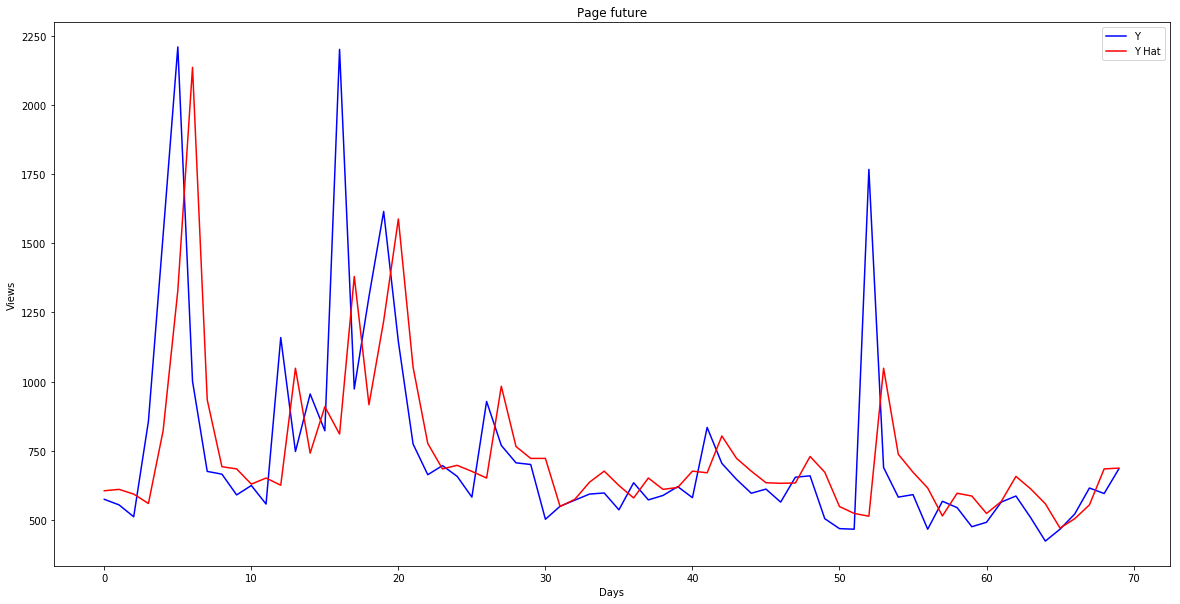

In [20]:
y = page['hits']
yhat = page['prediction']
plot_series(y,"Page future",new_plot=True,plot_show=False,label="Y")
plot_series(yhat,"Page future",new_plot=False,plot_show=True,label="Y Hat", color='red')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


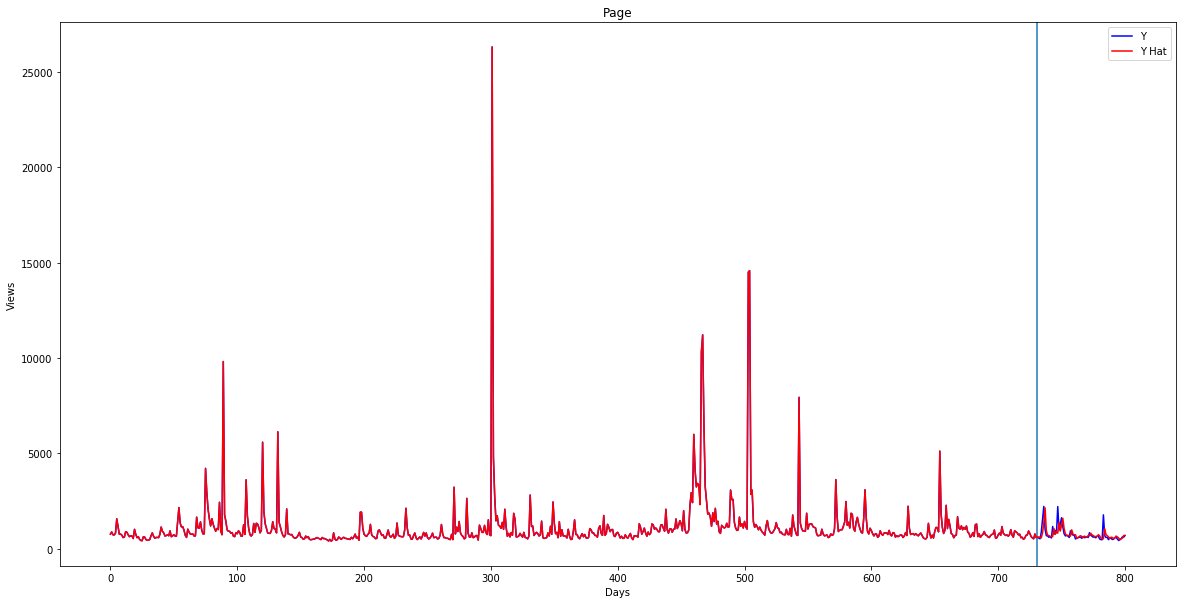

In [21]:
past = train[train['name'] == 33809.0][train['lang'] == 4.0][train['access'] == 0.0][train['agent'] == 0.0]
past = past['hits']
y_full = past.append(y)
yhat_full = past.append(yhat)
plot_series(y_full,"Page",new_plot=True,plot_show=False,label="Y")
plt.axvline(len(past))
plot_series(yhat_full,"Page",new_plot=False,plot_show=True,label="Y Hat", color='red')

In [26]:
mdl.booster_.save_model(path.join(root_folder,"lgbm.model"))

In [28]:
joblib.dump(mdl, path.join(root_folder,"lgbm.pkl"))

['./data/lgbm.pkl']